Number of columns before dropped columns: 1569
Number of columns after dropped columns: 205
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
This is fold 0
This is fold 1
This is fold 2
This is fold 3
This is fold 4
This is fold 5
This is fold 6
This is fold 7
This is fold 8
This is fold 9
These are the relevant features ['CKD-EPI eGFR', 'Length', 'Lipemische index', 'Hemolytische index', 'Kreatinine', 'Brief_RTH', 'Leukocyten', 'REU', 'Neurological', 'Dermatologic', '25-OH Vitamine D', 'Congenital anomalies', 'SUM', 'Gamma-GT', 'RDW', 'URO', 'Brief_PLA', 'Brief_DER', 'Brief_INT', 'Hematopoietic', 'Opnames_spec', 'Albumine', 'Digestive', 'Endocrine/metabolic', 'Ureum', 'Brief_OOG', 'Neoplasms', 'KNO', 'LDL-Cholesterol', 'Genitourinary', 'Calcium', 'LDH']
                                Accuracy Sensitivity Specificity  \
Model 1: Random Forest            [0.69]      [0.73]      [0.64]   
Model 2: Support Vector Machine   [0.61]      [0.62]       [0.6]   

  

IndexError: list index out of range

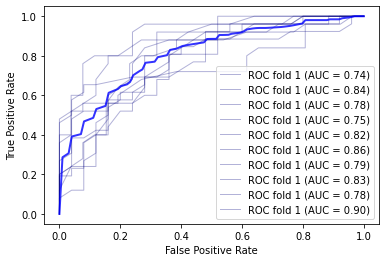

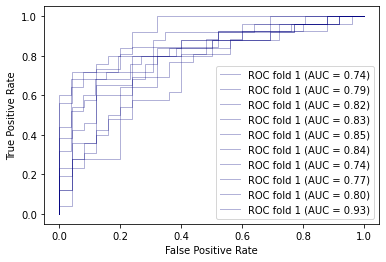

In [1]:

    # Define 10-fold stratified cross-validation
    cv_10fold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state= 4)

    for i, (train_index, val_index) in enumerate(cv_10fold.split(train_data, train_label)):    # Split the data in a train and validation set in a 10-fold cross-validation
        data_train = train_data.iloc[train_index]
        label_train = train_label.iloc[train_index]
        data_val = train_data.iloc[val_index]
        label_val = train_label.iloc[val_index]
    
        # Pre-processing steps
        # Impute data, but exclude the BMI in this. Add BMI again after imputation.
        impute_train, impute_val = impute_data(data_train, data_val, df_decimal) #imputes data for all columns 
        # Imputed length and weight, now calculate BMI from that and delete weight again
        impute_train['BMI'] = np.round(impute_train['Weight']/((impute_train['Length']/100)**2), decimals=2)
        impute_val['BMI'] = np.round(impute_val['Weight']/((impute_val['Length']/100)**2), decimals=2)
        impute_train = impute_train.loc[:,impute_train.columns!='Weight']
        impute_val = impute_val.loc[:,impute_val.columns!='Weight']

        # Find significant features per fold ## GEBRUIKEN WE DIT ERGENS UBERHAUPT? vgm niet
        # sign, sign_features_dfs = find_sign_features(impute_train, label_train, train_index, ordinal_keys, binary_keys, continuous_keys, sign_features_dfs)

        # Define classifiers
        clf_RF_all = RandomForestClassifier()
        # Fit and test the classifier
        clf_RF_all.fit(impute_train, label_train)
        predicted = clf_RF_all.predict(impute_val)

        # Create model
        #tprs_RF_all, aucs_RF_all, auc_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, gini_RF_all = pipeline_model4(impute_train, label_train, impute_val, label_val, clf_RF_all)
        result = permutation_importance(clf_RF_all, impute_val, label_val, n_repeats=10, random_state=42, n_jobs=2) 
        # Create dataframe to store the results
        df_feature_importance = pd.DataFrame({'Feature': (list(impute_train.columns)), 'Feature importance mean': result.importances_mean, 'Feature importance std': result.importances_std}) 
        # Sort dataframe with the most important features first. Keep only the 5 most important features with .head()
        df_feature_importance_sorted = df_feature_importance.sort_values(by=['Feature importance mean'], ascending=False).head()
        # Append dataframe to list per fold. The list consists of i dataframes for the number of folds, showing the best 5 features per fold. This dataframe can be used for visualization.
        perm_importances_dfs.append(df_feature_importance_sorted)

        print(f'This is fold {i}')

    # Now, create a dataframe with all duplicate features removed
    rel_features_df = pd.DataFrame()
    for fold in perm_importances_dfs:
        rel_features_df = pd.concat([rel_features_df, fold])
    rel_features_df = rel_features_df.drop_duplicates(subset=['Feature'])
    # Make a list of the relevant features
    rel_features = rel_features_df['Feature'].tolist()
    print(f'These are the relevant features {rel_features}')

    # hier een list maken om die boel in te storen
    final_features.append(rel_features)

    # Next, create new dataframes of the training and test data with only these relevant features and preprocess the data)
    # Pre-processing steps
    # Impute data
    impute_train_rel, impute_test_rel = impute_data(train_data, test_data, df_decimal)
    # Imputed length and weight, now calculate BMI from that and delete weight again
    impute_train_rel['BMI'] = np.round(impute_train_rel['Weight']/((impute_train_rel['Length']/100)**2), decimals=2)
    impute_test_rel['BMI'] = np.round(impute_test_rel['Weight']/((impute_test_rel['Length']/100)**2), decimals=2)
    impute_train_rel = impute_train_rel.loc[:,impute_train_rel.columns!='Weight']
    impute_test_rel = impute_test_rel.loc[:,impute_test_rel.columns!='Weight']

    # Select only the relevant features
    impute_train_fin = impute_train_rel[rel_features]
    impute_test_fin = impute_test_rel[rel_features]

    # Scale the data
    scale_train_rel, scale_test_rel = scale_data(impute_train_rel, impute_test_rel, continuous_keys, ordinal_keys)
    # Again, only select the relevant features
    scale_train_fin = scale_train_rel[rel_features]
    scale_test_fin = scale_test_rel[rel_features]

    # Train a SVM and RF classifier using all the training data and validate on the remaining 10% of unseen data
    # Define classifiers
    clf_RF_fin = RandomForestClassifier()
    clf_SVM_fin = SVC()

    # Random forest with significant features only: create model
    tprs_RF_fin, aucs_RF_fin, auc_RF_fin, spec_RF_fin, sens_RF_fin, accuracy_RF_fin, gini_RF_fin = pipeline_model(impute_train_fin, train_label, impute_test_fin, test_label, clf_RF_fin, tprs_RF_fin, aucs_RF_fin, spec_RF_fin, sens_RF_fin, accuracy_RF_fin, axis_RF_fin, gini_RF_fin)

    # Support vector machine with significant features only: create model with scaled data
    tprs_SVM_fin, aucs_SVM_fin, auc_SVM_fin, spec_SVM_fin, sens_SVM_fin, accuracy_SVM_fin, gini_SVM_fin = pipeline_model(scale_train_fin, train_label, scale_test_fin, test_label, clf_SVM_fin, tprs_SVM_fin, aucs_SVM_fin, spec_SVM_fin, sens_SVM_fin, accuracy_SVM_fin, axis_SVM_fin, gini_SVM_fin)

    # Create a dictionary of the scores for the two models. Create dataframe for visualisation.
    dict_scores = {'Model 1: Random Forest':[f'{np.round(accuracy_RF_fin, decimals = 2)}',
                                            f'{np.round(sens_RF_fin, decimals=2)}',
                                            f'{np.round(spec_RF_fin, decimals=2)}',
                                            f'{np.round(aucs_RF_fin,decimals=2)}',
                                            f'{np.round(gini_RF_fin,decimals=2)}'],
                'Model 2: Support Vector Machine':[f'{np.round(accuracy_SVM_fin,decimals=2)}',
                                            f'{np.round(sens_SVM_fin,decimals=2)}',
                                            f'{np.round(spec_SVM_fin,decimals=2)}',
                                            f'{np.round(aucs_SVM_fin,decimals=2)}',
                                            f'{np.round(gini_SVM_fin,decimals=2)}']}
    # performances.append(dict_scores)
    df_scores = pd.DataFrame.from_dict(dict_scores, orient='index', columns=['Accuracy', 'Sensitivity', 'Specificity', 'Area under ROC-curve','Gini index'])

    print(df_scores)
    print(f'This is outer fold {j}')

# Om de boel te kunnen analyseren is het van belang dat we opnieuw de data imputatie doen op de hele dataset en BMI creëren
# Impute data
impute_train_rel, impute_test_rel = impute_data(train_data, test_data, df_decimal)
# Imputed length and weight, now calculate BMI from that and delete weight again
impute_train_rel['BMI'] = np.round(impute_train_rel['Weight']/((impute_train_rel['Length']/100)**2), decimals=2)
impute_test_rel['BMI'] = np.round(impute_test_rel['Weight']/((impute_test_rel['Length']/100)**2), decimals=2)
impute_train_rel = impute_train_rel.loc[:,impute_train_rel.columns!='Weight']
impute_test_rel = impute_test_rel.loc[:,impute_test_rel.columns!='Weight']

# First, merge the train and test set together for a fuller data set
impute_tot = pd.concat([impute_train_rel, impute_test_rel])
label_tot = pd.concat([train_label, test_label])
# Then, merge the dataset with the labels again so they can be separated
impute_tot.index = np.arange(start = 0, stop = impute_tot.shape[0],step = 1)
label_tot.index = np.arange(start = 0, stop = impute_tot.shape[0],step = 1)
impute_tot = impute_tot.merge(label_tot.rename('Label'), left_index = True, right_index = True)

# Now separate the ID from the no ID group
gedoe_1 = impute_tot.loc[impute_tot['Label'] == 1.0]
gedoe_0 = impute_tot.loc[impute_tot['Label'] == 0.0]
BMI_mean_1 = np.round(np.nanmean(gedoe_1['BMI']),decimals=2) # ignores nan values
BMI_mean_0 =np.round(np.nanmean(gedoe_0['BMI']), decimals=2)
BMI_std_1 = np.round(np.nanstd(gedoe_1['BMI']), decimals=2)
BMI_std_0 = np.round(np.nanstd(gedoe_0['BMI']), decimals=2)

# This is by no means a perfect BMI calculation to use in the final tabel, but considering the current circumstances it is a satisfactory option.

# make plots
# Combine true positive rates, areas under curve and axes for plotting mean ROC curves
all_tprs = [tprs_RF_fin, tprs_SVM_fin]
all_aucs = [aucs_RF_fin, aucs_SVM_fin]
all_axes = [axis_RF_fin, axis_SVM_fin]

# Create plots of the ROC curves for the three models seperately and the mean ROC curves of the three models in one figure
mean_ROC_curves(all_tprs, all_aucs, all_axes)
plt.show()

# print(final_features)
# unpack the nested list 
final_features = [a for final_features in final_features for a in final_features]
dict_features = {x:final_features.count(x) for x in final_features}
print(dict_features)
df_features = pd.DataFrame.from_dict(dict_features, orient='index', columns=['Frequency'])
df_features.index.name = 'Feature'
df_features.to_excel("df_features.xlsx")

# export performance scores to excel
df_scores.to_excel("df_scores.xlsx", sheet_name="all_scores")

# also make a dataframe with the mean of all the performance scores that we also export to excel
# Create a dictionary of the scores for the two models. Create dataframe for visualisation.
dict_mean_scores = {'Model 1: Random Forest':[f'{np.round(np.mean(accuracy_RF_fin), decimals = 2)}',
                                            f'{np.round(np.mean(sens_RF_fin), decimals=2)}',
                                            f'{np.round(np.mean(spec_RF_fin), decimals=2)}',
                                            f'{np.round(np.mean(aucs_RF_fin),decimals=2)}',
                                            f'{np.round(np.mean(gini_RF_fin),decimals=2)}'],
                'Model 2: Support Vector Machine':[f'{np.round(np.mean(accuracy_SVM_fin),decimals=2)}',
                                            f'{np.round(np.mean(sens_SVM_fin),decimals=2)}',
                                            f'{np.round(np.mean(spec_SVM_fin),decimals=2)}',
                                            f'{np.round(np.mean(aucs_SVM_fin),decimals=2)}',
                                            f'{np.round(np.mean(gini_SVM_fin),decimals=2)}']}
# performances.append(dict_scores)
df_mean_scores = pd.DataFrame.from_dict(dict_scores, orient='index', columns=['Accuracy', 'Sensitivity', 'Specificity', 'Area under ROC-curve','Gini index'])
print(df_mean_scores)
df_mean_scores.to_excel("df_scores.xlsx", sheet_name="mean_scores")

# finding the differences in the relevant features
analysis = pd.DataFrame(columns = ('frequency', 'mean_ID', 'std_ID', 'mean_control', 'std_control'))
analysis.index.name = 'Feature'
continuous_keys2 = [x for x in continuous_keys if x != 'BMI'] # BMI bestaat namelijk nog niet in df_1_baseline en df_control, dus even weghalen

for key in dict_features:
    if key == 'BMI': # BMI bestaat namelijk nog niet in df_1_baseline en df_control
        analysis.loc[key] = [dict_features[key], BMI_mean_1, BMI_std_1, BMI_mean_0, BMI_std_0]
    if key in continuous_keys2:
        analysis.loc[key] = [dict_features[key], np.nanmean(df_1_baseline[key]), np.nanstd(df_1_baseline[key]), np.nanmean(df_control[key]), np.nanstd(df_control[key])] 
    if key in binary_keys:
        analysis.loc[key] = [dict_features[key], mode(df_1_baseline[key], nan_policy = 'omit'), np.NaN, mode(df_control[key], nan_policy = 'omit'), np.NaN]
    if key in ordinal_keys:
        analysis.loc[key] = [dict_features[key], np.nanmedian(df_1_baseline[key]), np.NaN, np.nanmedian(df_control[key]), np.NaN]

print(analysis)
analysis.to_excel("analysis.xlsx")





Number of columns before dropped columns: 1569
Number of columns after dropped columns: 205
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253
Number of ID subjects for analysis: 253
Number of controls for analysis: 253


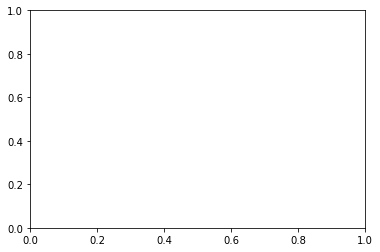

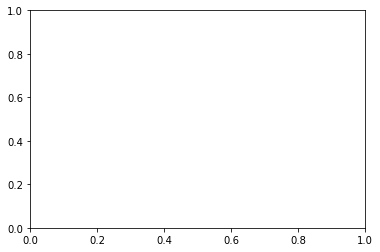

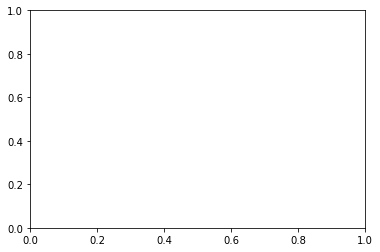

In [11]:
# LOG OF CHANGES
# nu goed kijken naar de plotjes

import os
import sys
clear = lambda: os.system('cls')  # On Windows System
clear()
sys.path.insert(0, r'C:\Users\linda\Dropbox\TM\Stagedocumenten\Q2 2021-2022\IDA-model-main\IDA-model\Functions')
# Import the right data packages
import pandas as pd
import numpy as np
import seaborn as sns
from v1_baseline import baseline
from v1_drop_data import drop_data
from v1_feature_selection import find_sign_features
from v1_impute_data import impute_data
from v1_load_data import load_data
from v1_mean_ROC_curves import mean_ROC_curves
from v1_pipeline_model import pipeline_model
#from v4_pipeline_model import pipeline_model4
from v1_scale_data import scale_data
from v1_stratify import stratify
from v1_syndromen import syndromen
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy import stats
from statistics import mean
from statistics import stdev
from statistics import mode
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from collections import Counter

# Load and merge data. Define paths and columns wanted from Excel files
path_data = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v6_dataset.xlsx'
columns_data = "A:BBB"
path_labels = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/IDA_aangevuld.xls'
columns_labels = "A:B"
path_phecodes = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/phecodes_filled_binary.xlsx'
columns_phecodes = "A:R"
path_specialisms = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/Letters_DBC_combined.xlsx'
columns_specialisms = "A:BW"
path_decimals = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/afronden_features.xlsx'
columns_decimals = 'A:HI'
path_baseline = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/baseline.xlsx'
columns_baseline = 'A:C'
path_extra = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v3_extra.xlsx'
columns_extra = 'A:D'
path_brieven = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v2_brieven.xlsx'
columns_brieven = 'A:BR'
path_syndromen = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v1_syndromen.xlsx'
columns_syndromen = 'A:B'

# df data contains most of the features needed to build the model
df_data = load_data(path_data, columns_data)
# df labels contains the label ID/ no ID
df_labels = load_data(path_labels, columns_labels)
# df phecodes contains the data about the diagnoses a patient has, categorized into groups
df_phecodes = load_data(path_phecodes, columns_phecodes)
# df spec contains the data about what specialisms a patient visited
df_spec = load_data(path_specialisms, columns_specialisms)
# df decimal contains the amount of decimals for rounding the different features
df_decimal = load_data(path_decimals, columns_decimals)
# df baseline contains baseline characteristics age and gender
df_baseline = load_data(path_baseline, columns_baseline)
# df_extra contains extra characteristics like BMI and opnames
df_extra = load_data(path_extra, columns_extra)
# df_brieven contains the letters sent from specialisms
df_brieven = load_data(path_brieven,columns_brieven)
# df_syndromen contains the PIDs and syndrome code
df_syndromen = load_data(path_syndromen,columns_syndromen)

# Merge dataframes
df_hix_spec = df_data.merge(df_spec, on='Pt_no', how='outer')
df_hix_phecodes = df_hix_spec.merge(df_phecodes, on='Pt_no', how='outer')
# In df hix, all features are merged inside one dataframe. The specialisms, phecodes and labels are added
df_hix = df_hix_phecodes.merge(df_labels, on='Pt_no', how='inner')
# Now add all the extra features
df_ex = df_hix.merge(df_extra, on='Pt_no',how = 'inner')
# Now add the letters from the specialisms
df_all = df_ex.merge(df_brieven, on = 'Pt_no', how = 'inner')
print('Number of columns before dropped columns: ' + str(len(df_all.columns)))

# Defining thresholds for dropping rows and columns with missing data (threshold of amount of non-NA values required)
threshold_column = 0.6
threshold_row = 0.5

# Drop columns and rows with too many NaN's
df_dropped = drop_data(threshold_column, threshold_row, df_all)
print('Number of columns after dropped columns: ' + str(len(df_dropped.columns)))

## Balance set by picking random samples from no ID group 
df_ID_1 = df_dropped.loc[df_dropped['Label'] == 1.0]
df_ID_0_all = df_dropped.loc[df_dropped['Label'] == 0.0]

# To perform stratified random sampling, the gender of the ID group is checked
# Merge the dataframes of ID and no ID with the baseline characteristics in df baseline (age and gender)
df_0_all_baseline = df_ID_0_all.merge(df_baseline, on='Pt_no', how='inner')
df_1_baseline = df_ID_1.merge(df_baseline, on='Pt_no', how='inner')
# Check baseline characteristics of subset
#characteristics = baseline(df_0_all_baseline, df_1_baseline)

# Stratify the data
df_control = stratify(df_0_all_baseline, df_1_baseline)
# Check baseline characteristics again after stratifying
# characteristics_stratified = baseline(df_control, df_1_baseline)

# Syndromen bekijken
control_count, ID_count, syndroom_control, syndroom_ID = syndromen(df_syndromen, df_control, df_1_baseline)


# Merge the dataframes from ID and no ID again
df_comb = pd.concat([df_1_baseline,df_control])
df_comb = df_comb.drop(['Leeftijd', 'Geslacht'], axis = 1 )

# Defining empty lists needed later
tprs_RF_all = []
aucs_RF_all = []
auc_RF_all = []
spec_RF_all = []
sens_RF_all = []
accuracy_RF_all = []
gini_RF_all = []
tprs_RF_fin = []
aucs_RF_fin = []
auc_RF_fin = []
spec_RF_fin = [] 
sens_RF_fin = []
accuracy_RF_fin = []
gini_RF_fin = []
tprs_SVM_fin = []
aucs_SVM_fin = [] 
auc_SVM_fin = []
spec_SVM_fin = [] 
sens_SVM_fin = []
gini_SVM_fin = []
accuracy_SVM_fin = []
accuracy_SVM_sign = []
perm_importances_dfs = []
sign_features_dfs = []
final_features = []
performances = []

# Define the necessary figures
_, axis_RF_fin = plt.subplots()
_, axis_SVM_fin = plt.subplots()
_, axis_models = plt.subplots()

# Define data and labels
labels = df_comb['Label']
data = df_comb.drop(['Pt_no', 'Label'], axis=1)

# Define ordinal, binary and continuous keys
ordinal_keys = ['Anti-epileptics', 'Psychofarmaca', 'Antacids', 'Anti-hypertensives', 'VitB12', 'Iron-tablets', 'Specialisms_hospitalization', 'Radiologic_investigations', 'Total_amount_ICD10s']
binary_keys = list(df_spec.keys()) + list(df_phecodes.keys()) + list(df_brieven.keys())
binary_keys.remove('Pt_no')
binary_keys.remove('Pt_no')
binary_keys.remove('Pt_no')
continuous_keys = ['Length', 'Opnames_spec', 'Beeldvormende_verr', 'HR', 'RRsyst', 'RRdiast', 'FSH', 'Vrij T4', 'Hemolytische index', 'Icterische index', 'Lipemische index', 'TSH', 'Alk.Fosf.', 'ALAT', 'Albumine', 'ASAT', 'Calcium', 'CKD-EPI eGFR', 'Glucose/PL', 'Hemoglobine', 'Kalium', 'Kreatinine', 'LDH', 'Leukocyten', 'MCV', 'Natrium', 'RDW', 'Tot. Bilirubine', 'Trombocyten', 'Gamma-GT', '25-OH Vitamine D', 'Ureum', 'LDL-Cholesterol', 'BMI']

# VANAF HIER ZOU DE GROTE LOOP MOETEN
big_cv_10fold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=22) # pshh yolo we gaan hem gewoon lang laten runnen
for j, (train_index, test_index) in enumerate(big_cv_10fold.split(df_comb, labels)):    # Split the data in a train and validation set in a 10-fold cross-validation
    train_data = df_comb.iloc[train_index]
    train_data = train_data.drop(['Pt_no', 'Label'], axis=1)
    train_label = labels.iloc[train_index]
    test_data = df_comb.iloc[test_index]
    test_data = test_data.drop(['Pt_no', 'Label'], axis=1)
    test_label = labels.iloc[test_index]

    # # Split the test data from the entire data set
    # train_data2, test_data2 = train_test_split(df_comb, test_size=0.1, random_state=5)
    # train_data = train_data2.drop(['Pt_no', 'Label'], axis=1)
    # test_data = test_data2.drop(['Pt_no', 'Label'], axis=1)
    # train_label = train_data2['Label']
    # test_label = test_data2['Label']

    # Syndromen bekijken
    # control_count, ID_count, syndroom_control, syndroom_ID = syndromen(df_syndromen, df_control, df_1_baseline)

    print('Number of ID subjects for analysis: ' + str(len(df_1_baseline.index)))
    print('Number of controls for analysis: ' + str(len(df_control.index)))


In [15]:
df_control['Geslacht'].value_counts()
#df_1_baseline['Geslacht'].value_counts()

1.0    139
0.0    114
Name: Geslacht, dtype: int64

[[array([0.        , 0.19230769, 0.19230769, 0.19230769, 0.23076923,
       0.23076923, 0.23076923, 0.23076923, 0.27000777, 0.27972028,
       0.28943279, 0.2991453 , 0.42307692, 0.42307692, 0.42307692,
       0.42307692, 0.54001554, 0.54972805, 0.55944056, 0.56915307,
       0.61538462, 0.61538462, 0.61538462, 0.61538462, 0.61771562,
       0.62742813, 0.63714064, 0.64685315, 0.69230769, 0.69230769,
       0.69230769, 0.69230769, 0.6954157 , 0.70512821, 0.71484071,
       0.72455322, 0.80769231, 0.80769231, 0.80769231, 0.80769231,
       0.80769231, 0.80769231, 0.80769231, 0.80769231, 0.80769231,
       0.80769231, 0.80769231, 0.80769231, 0.80769231, 0.80769231,
       0.80769231, 0.80769231, 0.88461538, 0.88461538, 0.88461538,
       0.88461538, 0.88461538, 0.88461538, 0.88461538, 0.88461538,
       0.88461538, 0.88461538, 0.88461538, 0.88461538, 0.88461538,
       0.88461538, 0.88461538, 0.88461538, 0.88461538, 0.88461538,
       0.88461538, 0.88461538, 0.89160839, 0.9013209 , 0.911

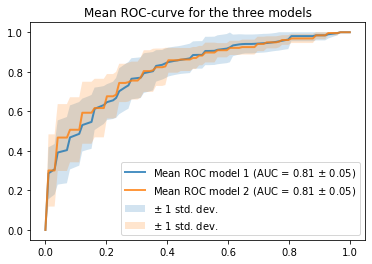

In [10]:
# make plots
from v1_mean_ROC_curves import mean_ROC_curves
# Combine true positive rates, areas under curve and axes for plotting mean ROC curves
_, axis_models = plt.subplots()

all_tprs = [tprs_RF_fin, tprs_SVM_fin]
all_aucs = [aucs_RF_fin, aucs_SVM_fin]
all_axes = [axis_RF_fin, axis_SVM_fin, axis_models]

print(all_tprs)
print(all_aucs)
print(all_axes)
#print(all_axes[1])
# Create plots of the ROC curves for the three models seperately and the mean ROC curves of the three models in one figure
mean_ROC_curves(all_tprs, all_aucs, all_axes)
plt.show()